# Gaia DR2 variability catalogs
### Part I: What's in them?

gully  
May 2, 2018

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
! du -hs ../data/dr2/Gaia/gdr2/vari_classifier_result/csv

5.7M	../data/dr2/Gaia/gdr2/vari_classifier_result/csv


In [3]:
df0 = pd.read_csv('../data/dr2/Gaia/gdr2/vari_classifier_result/csv/VariClassifierResult_0.csv.gz')

In [4]:
df0.shape

(7255, 5)

In [5]:
df0.head()

,solution_id,source_id,classifier_name,best_class_name,best_class_score
0,369295546864633574,2915501251673548032,nTransits:2+,MIRA_SR,0.800170
1,369295546864633574,2915687000420285568,nTransits:2+,RRC,0.660132
2,369295546864633574,2915997715534807168,nTransits:2+,MIRA_SR,0.995748
3,369295546864633574,2916244830772710784,nTransits:2+,RRAB,0.955541
4,369295546864633574,2916286406055828480,nTransits:2+,RRAB,1.000000


The catalog is not too long.  We can just read in all the files and concatenate them

In [6]:
import glob

In [7]:
fns = glob.glob('../data/dr2/Gaia/gdr2/vari_classifier_result/csv/VariClassifierResult_*.csv.gz')

In [8]:
n_files = len(fns)

In [9]:
df_classifier = pd.DataFrame()

This step only takes 1 second:

In [10]:
for i, fn in enumerate(fns):
    df_i = pd.read_csv(fn)
    df_classifier = df_classifier.append(df_i, ignore_index=True)

In [11]:
df_classifier.shape

(363969, 5)

Ok, we have 363,969 classifications of variable stars, which matches exactly with the number presented in Table 1 of [Brown et al. 2018](https://www.aanda.org/component/article?access=doi&doi=10.1051/0004-6361/201833051).  What are the categories?

In [12]:
df_classifier.best_class_name.value_counts()

RRAB          162469
MIRA_SR       150757
RRC            32370
DSCT_SXPHE      8882
CEP             6493
T2CEP           1743
RRD              834
ACEP             314
ARRD             107
Name: best_class_name, dtype: int64

Section 7.3.3 of the [Gaia DR2 Documentation](http://gea.esac.esa.int/archive/documentation/GDR2/Data_analysis/chap_cu7var/ssec_cu7var_sos_allsky/ssec_cu7var_allsky_proc.html) lists the classification code definition.

> The training set included objects of the classes targeted for publication in Gaia DR2 (listed in bold) as well as other types to reduce the contamination of the published classification results. The full list of object classes, with labels (used in the rest of this section) and corresponding descriptions, follows below.

20. **RRAB**: Fundamental-mode RR Lyrae stars.
16. **MIRA**: Long period variable stars of the o (omicron) Ceti type (Mira).
28. **SR**: Long period variable stars of the semiregular type.
21. **RRC**: First-overtone RR Lyrae stars.
10. **DSCT**: δ Scuti-type stars.
27. **SXPHE**: SX Phoenicis-type stars.
7. **CEP**: Classical (δ) Cepheids.
29. **T2CEP**: Type-II Cepheids.
22. **RRD**: Double-mode RR Lyrae stars.
1. **ACEP**: Anomalous Cepheids.
4. **ARRD**: Anomalous double-mode RR Lyrae stars.


The stars I'm interested in are not automatically classified, but are used in *training* the classifier that labels these stars.  That's too bad, I'd like to see the lightcurves for these classes:

2. ACV: α2 Canum Venaticorum-type stars.
8. CONSTANT: Objects whose variations (or absence thereof) are consistent with those of constant sources (Section 7.2.3).
11. ECL: Eclipsing binary stars.
13. FLARES: Magnetically active stars displaying flares.
19. ROT: Rotation modulation in solar-like stars due to magnetic activity (spots).
23. RS: RS Canum Venaticorum-type stars.
24. SOLARLIKE: Stars with solar-like variability induced by magnetic activity (flares, spots, and rotational modulation).

Oh well, looks like these desired classifications may ellude us for now.  What's the deal with the classifier name column?  Section 7.3.1 of the Documentation explains:
> The results of this classification can be found in the Gaia DR2 archive in the classification table associated with the `nTransits:2+` classifier, although subsequent filtering [...] increased the minimum number of FoV transits to five

In [13]:
df_classifier.classifier_name.value_counts()

nTransits:2+    363969
Name: classifier_name, dtype: int64

They all have the same entry, so let's drop this column.

In [14]:
df_classifier.drop(columns='classifier_name', inplace=True)

What is the distribution of best class scores?

Text(0,0.5,'$N$')

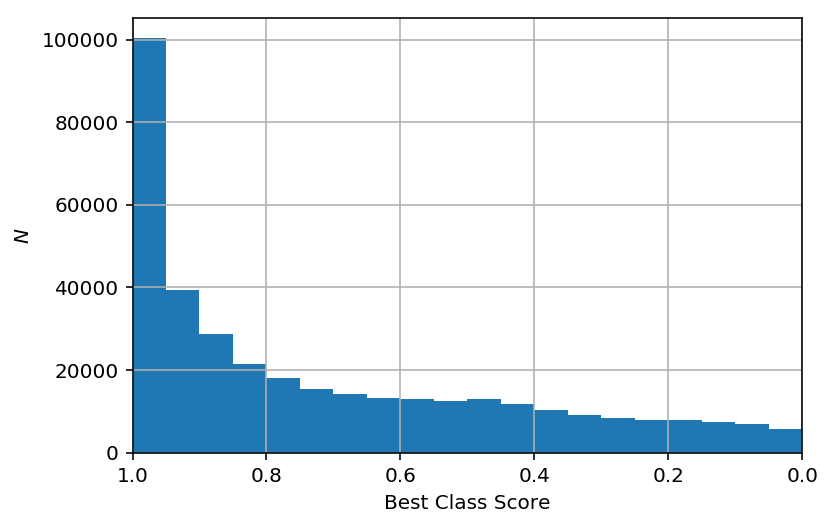

In [15]:
df_classifier.best_class_score.hist(bins=20)
plt.xlim(1, 0)
plt.xlabel('Best Class Score')
plt.ylabel('$N$')

Many sources have best class scores close to 1.  How do the classifications break down by Class?

In [16]:
df_summary = df_classifier.groupby('best_class_name').best_class_score.describe()

In [17]:
df_summary.style.format({key: "{:.0%}" for key in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']})

,count,mean,std,min,25%,50%,75%,max
best_class_name,,,,,,,,
ACEP,314,42%,16%,17%,28%,38%,56%,83%
ARRD,107,28%,17%,7%,15%,25%,36%,72%
CEP,6493,56%,27%,0%,35%,59%,79%,100%
DSCT_SXPHE,8882,32%,18%,0%,17%,28%,43%,95%
MIRA_SR,150757,87%,19%,0%,84%,95%,100%,100%
RRAB,162469,66%,27%,0%,46%,71%,90%,100%
RRC,32370,43%,25%,0%,21%,43%,63%,99%
RRD,834,42%,14%,9%,32%,39%,49%,86%
T2CEP,1743,30%,19%,0%,15%,29%,43%,91%


Comparing the classification score between types might not be trivial, depending on what assumptions are made in the classifier (the prior probabilities vary drastically).  For example, if you made a classifier that guessed `MIRA_SR`, you would be right 41% of the time.  Finding annomalous Cepheids is a needle-in-a-haystack problem.

In [18]:
df_summary['parent_fraction'] = df_summary['count']/df_summary['count'].sum()
df_summary.style.format({key: "{:.0%}" for key in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']}
                       ).format({'parent_fraction': "{:.2%}"})

,count,mean,std,min,25%,50%,75%,max,parent_fraction
best_class_name,,,,,,,,,
ACEP,314,42%,16%,17%,28%,38%,56%,83%,0.09%
ARRD,107,28%,17%,7%,15%,25%,36%,72%,0.03%
CEP,6493,56%,27%,0%,35%,59%,79%,100%,1.78%
DSCT_SXPHE,8882,32%,18%,0%,17%,28%,43%,95%,2.44%
MIRA_SR,150757,87%,19%,0%,84%,95%,100%,100%,41.42%
RRAB,162469,66%,27%,0%,46%,71%,90%,100%,44.64%
RRC,32370,43%,25%,0%,21%,43%,63%,99%,8.89%
RRD,834,42%,14%,9%,32%,39%,49%,86%,0.23%
T2CEP,1743,30%,19%,0%,15%,29%,43%,91%,0.48%


The next thing we could do is match the Gaia `Source ID` with the main catalog to get RA and DEC values to then cross-match with Kepler/K2.